In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

from scipy.stats import levene,ttest_ind

## ETL: Extract, Transform, Load

ETL is a vital data integration process with three key stages:

- **Extract**: Gather data from databases, files, or web services.
- **Transform**: Clean, structure, and prepare data for analysis.
- **Load**: Store data in a data warehouse or database for querying.

ETL ensures data is well-organized, clean, and ready for efficient analysis, making it essential for data projects and system integration.


In [5]:
df = pd.read_csv("/home/jony/Proyects/test_cat/cookie_cats.csv").drop("userid", axis=1)

In [6]:
df.head()

,version,sum_gamerounds,retention_1,retention_7
0,gate_30,3,False,False
1,gate_30,38,True,False
2,gate_40,165,True,False
3,gate_40,1,False,False
4,gate_40,179,True,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   version         90189 non-null  object
 1   sum_gamerounds  90189 non-null  int64 
 2   retention_1     90189 non-null  bool  
 3   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(1), object(1)
memory usage: 1.5+ MB


In [8]:
df.describe()

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


In [9]:
df.groupby("version")["sum_gamerounds"].agg(["count","mean","median","min","max"])

,count,mean,median,min,max
version,,,,,
gate_30,44700,52.456264,17.0,0,49854
gate_40,45489,51.298776,16.0,0,2640


## Managing Outliers in Game Rounds Analysis

When comparing the mean and the median of the "sum_gamerounds" data, we observe a significant difference between them. This discrepancy indicates that outliers, which are extreme values in the dataset, have a noticeable impact on the mean while the median remains relatively unaffected.

To effectively manage these outliers, we first identify them using statistical thresholds based on the data's distribution:


In [10]:
# Calculate percentiles and IQR
seventy_fifth = df["sum_gamerounds"].quantile(0.75)
twenty_fifth = df["sum_gamerounds"].quantile(0.25)
gamerounds_iqr = seventy_fifth - twenty_fifth

In [11]:
# Define upper and lower thresholds
upper = seventy_fifth + (1.5 * gamerounds_iqr)
lower = twenty_fifth - (1.5 * gamerounds_iqr)
print("Upper Threshold:", upper)
print("Lower Threshold:", lower)

Upper Threshold: 120.0
Lower Threshold: -64.0


#### Calculate percentage of outliers

In [12]:
outliers_percent = len(df[df["sum_gamerounds"] > upper]) / len(df) * 100
print("Percentage of Outliers:", outliers_percent)

Percentage of Outliers: 11.284081207242568


In [13]:
outliers_lower_percent = len(df[df["sum_gamerounds"] < lower]) / len(df) * 100
print("Percentage of Outliers:", outliers_lower_percent)

Percentage of Outliers: 0.0


These thresholds help us identify values that lie significantly beyond the typical range observed in the data.

#### Considerations before removing outliers:

- **Distribution of the data**: If the data follows a normal or nearly normal distribution, removing 11% of the data could eliminate some extreme but valid values. This could affect how we perceive the dataset overall.

- **Impact on analysis**: Removing a large portion of the dataset, especially if it's not very large to begin with, can significantly affect future analyses. It's important to consider whether removing extreme values is truly necessary for the analysis goals and if there are alternative ways to handle them.

- **Interpreting each extreme value**: It's important to understand whether extreme values are genuinely rare or simply data points that are unusually high or low. Sometimes, these extreme values can provide valuable insights into special user behaviors or specific conditions worth considering.

## Scatter Plot of Sum of Game Rounds (Original Data)

Text(0, 0.5, 'Sum Game Rounds')

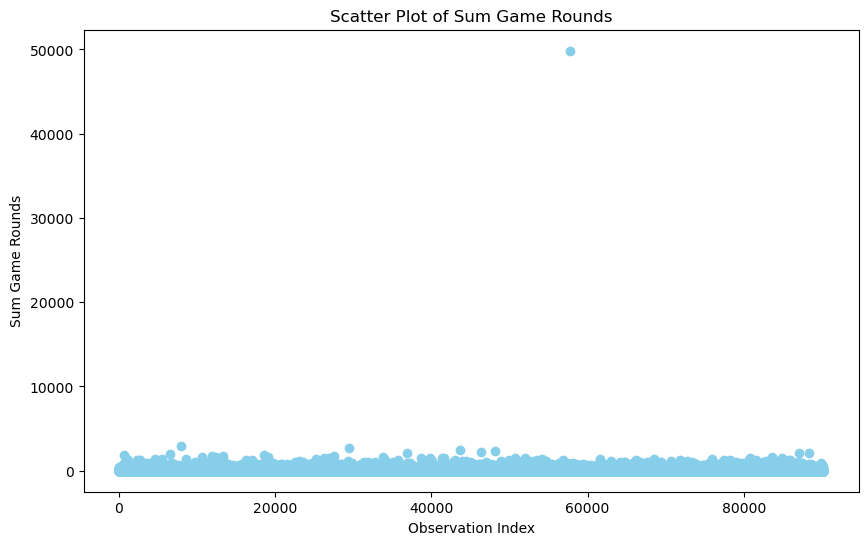

In [288]:
fig, ax = plt.subplots(figsize=(10, 6))


ax.scatter(df.index, df["sum_gamerounds"], marker="o", color="skyblue")

ax.set_title("Scatter Plot of Sum Game Rounds")
ax.set_xlabel("Observation Index")
ax.set_ylabel("Sum Game Rounds")

## Cleaning Data with Excessively High Game Rounds Sum

Data was removed for game instances where the total number of rounds played ("sum_gamerounds") exceeded 10,000. This action was taken to manage outliers that could potentially distort the analysis. Below is an outline of the process:

In [26]:
df_clean = df.drop(df[df["sum_gamerounds"] > 10000].index)
print("Shape of cleaned dataframe:", df_clean.shape)

Shape of cleaned dataframe: (90188, 4)


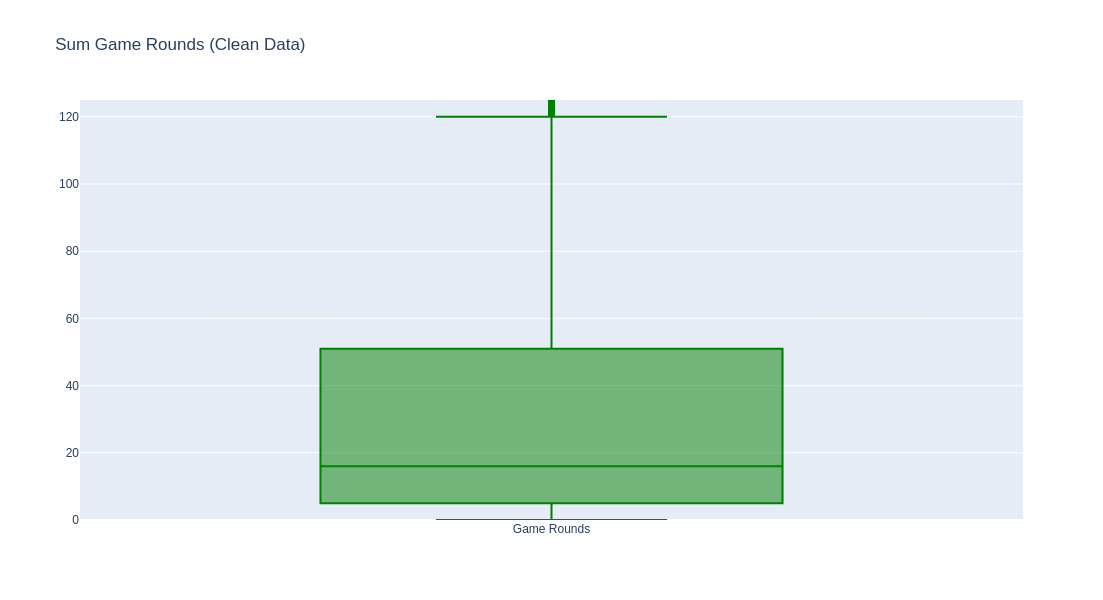

In [53]:
fig = go.Figure()

fig.add_trace(go.Box(y=df_clean["sum_gamerounds"],
                     name="Game Rounds",
                     marker_color="green"
))

fig.update_layout(yaxis=dict(range=[0, 125]),
                  title='Sum Game Rounds (Clean Data)',
                  height=600,
                  width=600,
                  
)

## Different chart by Version

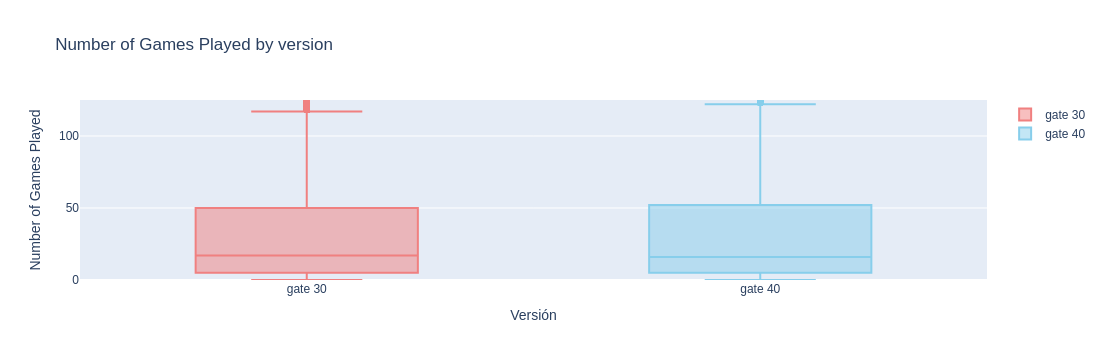

In [279]:
fig = go.Figure()

fig.add_trace(go.Box(y=df_clean[df_clean["version"] == "gate_30"]["sum_gamerounds"],
                     name="gate 30",
                     marker_color="lightcoral"
))

fig.add_trace(go.Box(y=df_clean[df_clean["version"] == "gate_40"]["sum_gamerounds"],
                     name="gate 40",
                     marker_color="skyblue"
))

fig.update_layout(title="Number of Games Played by version",
                  xaxis_title="Versión",
                  yaxis_title="Number of Games Played",
                  yaxis=dict(range=[0, 125]),
                  height=600
)

fig

In [280]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=version_counts.index,
    y=version_counts.values,
    marker_color=["skyblue", "lightcoral"],
    text=version_counts.values, 
))

fig.update_layout(
    title="Count of Observations by Version",
    xaxis_title="Version",
    yaxis_title="Count",
    showlegend=False,
    height=600
)

fig

## Line Plot of Number of Games Played by version

This plot visualizes the evolution of the total number of game rounds played across different observations for each version


Text(0, 0.5, 'Sum Game Rounds')

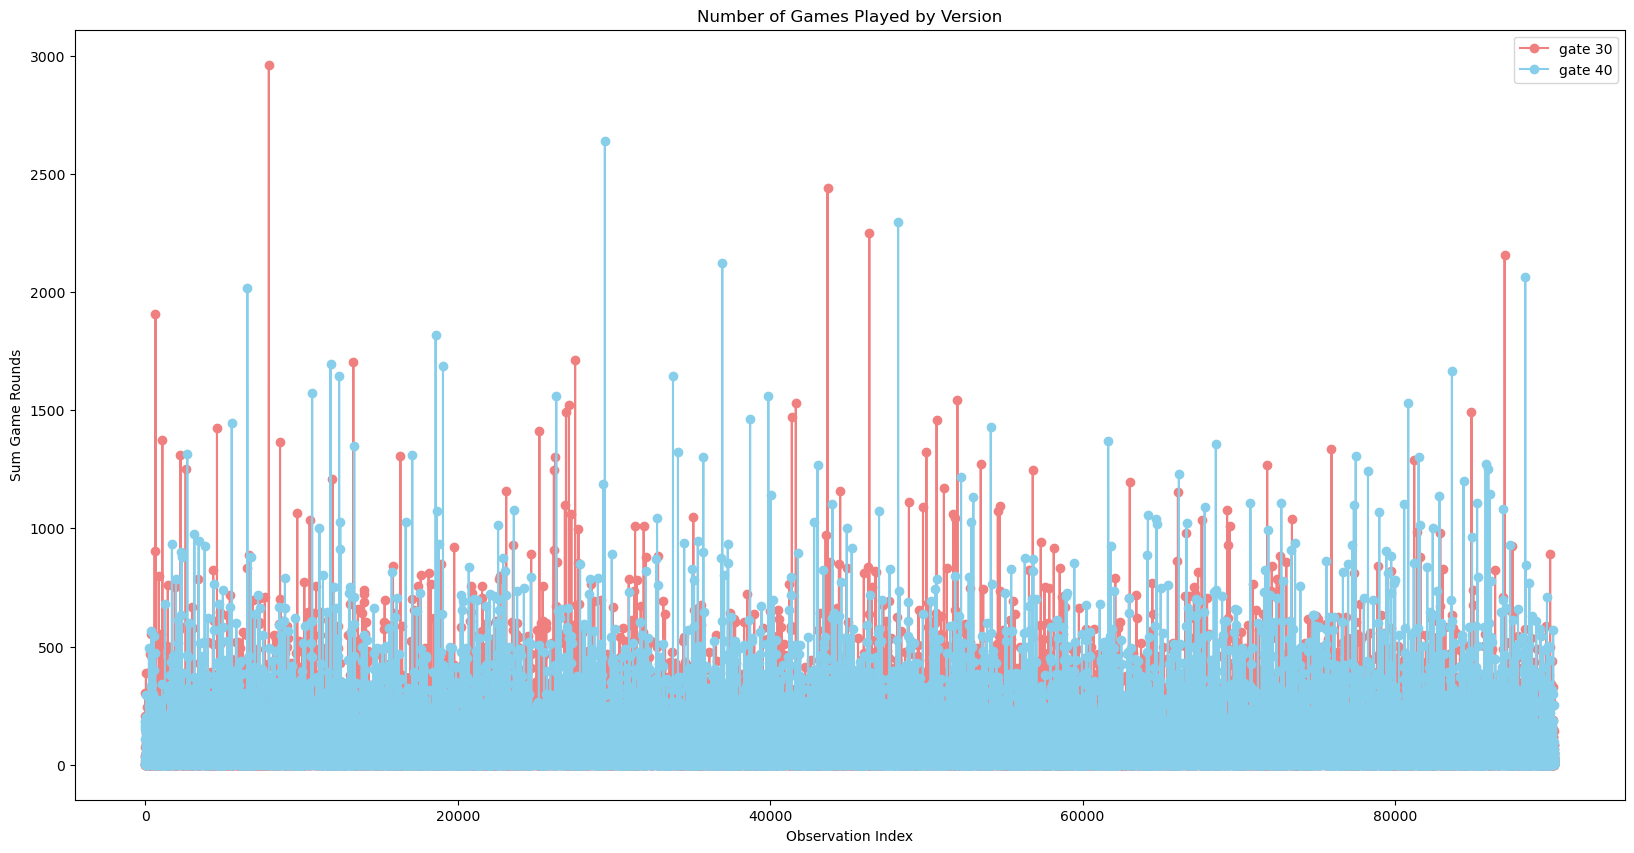

In [290]:
plt.figure(figsize=(20, 10))

data_gate_30 = df_clean[df_clean["version"] == "gate_30"]
data_gate_40 = df_clean[df_clean["version"] == "gate_40"]

plt.plot(data_gate_30.index, data_gate_30["sum_gamerounds"], label="gate 30", marker="o", color="lightcoral")
plt.plot(data_gate_40.index, data_gate_40["sum_gamerounds"], label="gate 40", marker="o", color="skyblue")

plt.legend()
plt.title("Number of Games Played by Version")
plt.xlabel("Observation Index")
plt.ylabel("Sum Game Rounds")

## Day 1 and Day 7 Retention Analysis by Version

In [282]:
df_gate_30 = df[df["version"] == "gate_30"]
df_gate_40 = df[df['version'] == "gate_40"]

# Calculate retention day 1 and day 7 for gate_30
retention_1_gate_30 = (df_gate_30["retention_1"].sum() / df_gate_30.shape[0]) * 100
retention_7_gate_30 = (df_gate_30["retention_7"].sum() / df_gate_30.shape[0]) * 100

# Calculate retention day 1 and day 7 for gate_40
retention_1_gate_40 = (df_gate_40["retention_1"].sum() / df_gate_40.shape[0]) * 100
retention_7_gate_40 = (df_gate_40["retention_7"].sum() / df_gate_40.shape[0]) * 100


print("Retention for gate 30:")
print(f"Retention day 1: {retention_1_gate_30:.2f}%")
print(f"Retention day 7: {retention_7_gate_30:.2f}%")
print()
print("Retention for gate 40:")
print(f"Retention day 1: {retention_1_gate_40:.2f}%")
print(f"Retention day 7: {retention_7_gate_40:.2f}%")

Retention for gate 30:
Retention day 1: 44.82%
Retention day 7: 19.02%

Retention for gate 40:
Retention day 1: 44.23%
Retention day 7: 18.20%


## Now that we have completed our data analysis, we are ready to proceed with the A/B test using hypothesis testing:

#### A/B Test

Before conducting the hypothesis test, it is important to validate the following assumptions:

1. **Adequate Sample Size:** The sample size is sufficiently large to mitigate uncertainty, allowing the Central Limit Theorem to apply. The required number of observations depends on the specific statistical test.

2. **Homogeneity of Variances:** The variances among the groups or samples being compared should be approximately equal.

3. **Random Sampling:** The samples are randomly selected subsets from larger populations.

4. **Normal Distribution:** Ideally, the data should follow a normal distribution.

5. **Independence of Observations:** Each observation (row) in the dataset is independent.

## Student's t-test to compare means between groups

In [283]:
t_stat_ret1, pvalue_ret1 = ttest_ind(df_gate_30["retention_1"], df_gate_40["retention_1"], equal_var=False)


if pvalue_ret1 > 0.05:
    print("There is no statistically significant difference in retention_1 between gate_30 and gate_40")
else:
    print("There is a statistically significant difference in retention_1 between gate_30 and gate_40")
print(f'Test Statistic = {t_stat_ret1:.4f}, p-value = {pvalue_ret1:.4f}')

There is no statistically significant difference in retention_1 between gate_30 and gate_40
Test Statistic = 1.7841, p-value = 0.0744


In [284]:
t_stat_ret7, pvalue_ret7 = ttest_ind(df_gate_30["retention_7"], df_gate_40["retention_7"], equal_var=False)

if pvalue_ret7 > 0.05:
    print("There is no statistically significant difference in retention_7 between gate_30 and gate_40")
else:
    print("There is a statistically significant difference in retention_7 between gate_30 and gate_40")
print(f'Test Statistic = {t_stat_ret7:.4f}, p-value = {pvalue_ret7:.4f}')

There is a statistically significant difference in retention_7 between gate_30 and gate_40
Test Statistic = 3.1640, p-value = 0.0016


## Levene's test for equality of variances

In [285]:
levene_stat1, levene_pvalue1 = levene(df_gate_30["retention_1"],df_gate_40["retention_1"])
levene_stat7, levene_pvalue7 = levene(df_gate_30["retention_7"], df_gate_40["retention_7"])

In [286]:
print("Levene's Test Results:")
print(f"For retention 1:")
print(f"Statistic: {levene_stat1:.4f}")
print(f"P-value: {levene_pvalue1:.4f}")
print()
print(f"For retention 7:")
print(f"Statistic: {levene_stat7:.4f}")
print(f"P-value: {levene_pvalue7:.4f}")

Levene's Test Results:
For retention 1:
Statistic: 3.1830
P-value: 0.0744

For retention 7:
Statistic: 10.0141
P-value: 0.0016
